In [53]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import numpy as np
import csv
from scipy import stats
import trompy as tp
import pandas as pd
from statsmodels.stats.anova import AnovaRM

%matplotlib inline

In [2]:
# fig settings
scattersize=50
colors = ['darkturquoise','dodgerblue', 'darkblue']

In [3]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
statsfolder = "C:\\Github\\Distraction-Paper\\stats\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [4]:
# thph2.8 removed from analysis because no data on habituation day

modDict.pop('thph2.8')
disDict.pop('thph2.8')
;

''

In [ ]:
def get_rms(daydict):
    
    """ Gets rms for all rats"""
    rms = []

    rats = daydict.keys()
    for rat in rats:
        d = daydict[rat]
        rms.append(d["rms"])
        
    return rms

rms_mod = get_rms(modDict)
rms_dis = get_rms(disDict)
rms_hab = get_rms(habDict)

In [67]:
def get_epoch_auc(daydict, signal="filt", epoch=[0, 40], predp_threshold=5):
    """Gets average baseline on trials from filtered, non-zscored signal"""
    
    baseline_auc = []
    
    rats = daydict.keys()
    for rat in rats:
        d = daydict[rat]
        
        bl = [np.mean(snip[epoch[0]:epoch[1]]) for snip, predp in zip(d["snips_distractors"][signal], d["pre_dp"]) if (predp > predp_threshold)]
        baseline_auc.append(np.mean(bl))
        
    return baseline_auc

threshold = 0

epoch = [0, 40]

mod_bl = get_epoch_auc(modDict, predp_threshold=threshold, epoch=epoch)
dis_bl = get_epoch_auc(disDict, predp_threshold=threshold, epoch=epoch)
hab_bl = get_epoch_auc(habDict, predp_threshold=threshold, epoch=epoch)

epoch = [60, 90]

mod_ep2 = get_epoch_auc(modDict, predp_threshold=threshold, epoch=epoch)
dis_ep2 = get_epoch_auc(disDict, predp_threshold=threshold, epoch=epoch)
hab_ep2 = get_epoch_auc(habDict, predp_threshold=threshold, epoch=epoch)

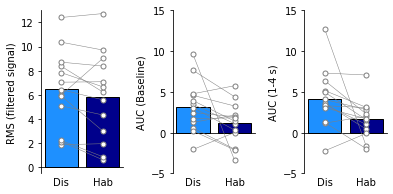

In [73]:
f, [ax1, ax2, ax3] = plt.subplots(figsize=(6,3), ncols=3)
f.subplots_adjust(left=0.1, wspace=0.6)

_, barx, _, _ = tp.barscatter([rms_dis, rms_hab], paired=True,
           barfacecolor=colors[1:], barfacecoloroption='individual',
           scattersize=scattersize,
           ax=ax1)

ax1.set_ylabel('RMS (filtered signal)')
ax1.set_ylim([-0.5, 13])

tp.barscatter([dis_bl, hab_bl], paired=True,
           barfacecolor=colors[1:], barfacecoloroption='individual',
           scattersize=scattersize,
           ax=ax2)

ax2.set_ylabel('AUC (Baseline)')
ax2.set_yticks([-5, 0, 5, 10, 15])

tp.barscatter([dis_ep2, hab_ep2], paired=True,
           barfacecolor=colors[1:], barfacecoloroption='individual',
           scattersize=scattersize,
           ax=ax3)

ax3.set_ylabel('AUC (1-4 s)')
ax3.set_yticks([-5, 0, 5, 10, 15])

barlabels=['Dis', 'Hab']

for axis in [ax1, ax2, ax3]:
    trans = transforms.blended_transform_factory(
                axis.transData, axis.transAxes)
    for x, label in zip(barx, barlabels):
        axis.text(x, -0.07, label, ha="center", transform=trans)

f.savefig(figfolder+"figs6_rms_and_bl.pdf")

In [71]:
t, p = stats.ttest_rel(rms_dis, rms_hab)
print('RMS (Dis) vs RMS (Hab)', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(dis_bl, hab_bl)
print('BL (Dis) vs BL (Hab)', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(dis_ep2, hab_ep2)
print('E2 (Dis) vs E2 (Hab)', t, p, "Sidak:", tp.sidakcorr(p))

RMS (Dis) vs RMS (Hab) 1.5850746150417214 0.13893468636891437 Sidak: 0.36157735288204806
BL (Dis) vs BL (Hab) 1.9840900717804237 0.07059629188121051 Sidak: 0.19718920673261564
E2 (Dis) vs E2 (Hab) 2.2776439210309 0.04185609230875025 Sidak: 0.12038580858307979


### Old stuff below here

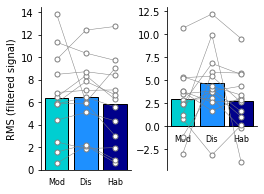

In [30]:
f, [ax1, ax2] = plt.subplots(figsize=(6,3), ncols=2)
f.subplots_adjust(left=0.4, wspace=0.4)
tp.barscatter([rms_mod, rms_dis, rms_hab], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           barlabels=['Mod', 'Dis', 'Hab'],
           barlabeloffset=0.05,
           scattersize=scattersize,
           ax=ax1)

ax1.set_ylabel('RMS (filtered signal)')
ax1.set_xticks([])
# ax.set_xticks([1,2,3])
# ax.set_xticklabels(['Mod', 'Dis', 'Hab'])
# ax.set_ylim([-0.1, 1.1])

tp.barscatter([mod_bl, dis_bl, hab_bl], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           barlabels=['Mod', 'Dis', 'Hab'],
           barlabeloffset=0.05,
           scattersize=scattersize,
           ax=ax2)

# f.savefig(figfolder+"figs5_rms.pdf")

In [31]:


rats = disDict.keys()
data = np.array([rms_mod, rms_dis, rms_hab], dtype="float").T


df = pd.DataFrame(data, columns=["mod", "dis", "hab"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)

# print("Mean of WN is", np.mean(wn_prob))
# print("Mean of Tone is", np.mean(tone_prob))
# print("Mean of Comb is", np.mean(combined_prob))

# t, p = stats.ttest_rel(wn_prob, tone_prob)
# print('WN vs Tone', t, p, "Sidak:", tp.sidakcorr(p))

# t, p = stats.ttest_rel(tone_prob, combined_prob)
# print('Tone vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

# t, p = stats.ttest_rel(wn_prob, combined_prob)
# print('WN vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  0.7556 2.0000 24.0000 0.4806



In [50]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from scipy import stats

rats = disDict.keys()
data = np.array([mod_bl, dis_bl, hab_bl], dtype="float").T


df = pd.DataFrame(data, columns=["mod", "dis", "hab"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)

# print("Mean of WN is", np.mean(wn_prob))
# print("Mean of Tone is", np.mean(tone_prob))
# print("Mean of Comb is", np.mean(combined_prob))

t, p = stats.ttest_rel(dis_bl, hab_bl)
print('WN vs Tone', t, p, "Sidak:", tp.sidakcorr(p))

# t, p = stats.ttest_rel(tone_prob, combined_prob)
# print('Tone vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

# t, p = stats.ttest_rel(wn_prob, combined_prob)
# print('WN vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  3.4163 2.0000 24.0000 0.0495

WN vs Tone 1.9840900717804237 0.07059629188121051 Sidak: 0.19718920673261564
